<a href="https://colab.research.google.com/github/goelnikhils-lgtm/languagemodels/blob/main/Reinforcement_Learning_Fine_Tuning_of_LLM_Sample_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#RLHF based fine tuning - sample code but not working code
#credit - https://medium.com/@meeran03/fine-tuning-llms-with-human-feedback-rlhf-latest-techniques-and-best-practices-3ed534cf9828
#credit - https://www.youtube.com/watch?v=R2paulc3P2M

In [ ]:
!pip install trl

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from transformers import AutoTokenizer, pipeline , AutoModelForSequenceClassification
from datasets import load_dataset

In [ ]:
model_name = "lvwerra/gpt-imdb" # base model
model = AutoModelForCausalLMWithValueHead.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

#initiate a reward model
reward_model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb")

#intialize PPO trainer with model , reward model and reference model for KL regularization
ppo_trainer = PPOTrainer(model=model,
                         ref_model=model,
                         toekizer = tokenizer,
                         reward_model = reward_model,
                         **ppo_params)
#prepare prompts for training
prompts = ["User: How can I improve my time management? Assistant:",
           "User: Tell me about the benefits of meditation? Assistant:"]
#start training loop
for epoch in enumerate(num_epochs):
  for prompt in prompts:
    input = tokenizer(prompt,return_tensor="pt")
    response_ids = model.generate(**input,max_new_tokens=100)
    response = tokenizer.decode(response_ids[0,input['inputs_id'].shape[1]:])
    reward_score = compute_reward_score(reward_model,prompt,response)
    ppo_trainer.step([prompt],[response],reward_model)
    print(response)

In [ ]:
#Second Code for fine tuning LLM with PPO - THE TASK IS SUMMARIZATION AND HENCE THE POLICY MODEL IS TRAINED ON THIS TASKS
#to give better results

import random
import numpy as np
import torch
import pandas as pd

from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    set_seed,
    Trainer,
    TrainingArguments,
    default_data_collator
)

def set_seed(seed_value=42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

output_dir = "supervised-summarize-checkpoint"
train_size = 16
gradient_accumlation_steps = 1
learning_rate = 1e-5
eval_batch_size = 1
eval_steps = 500
max_input_length = 550
save_steps = 1000
num_train_epochs = 20
random.seed(42)

In [ ]:
#create policy model
df = pd.read_parquet("/content/sample_data/test_policy.parquet")
df.iloc[12]

In [ ]:
import json
import pandas as pd
import torch
from datasets import load_dataset
from torch.utils.data import Dataset
from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    set_seed,
    Trainer,
    TrainingArguments,
    default_data_collator
)
class TLDRDataset(Dataset):
  def __init__(self,train_path,tokenizer,split,max_input_length = 256):
    self.post_list=[]
    dataset = pd.read_parquet(train_path)
    self.labels = []
    for sample in dataset.iterrows():
      self.post_list.append(sample[1]["prompt"])
      self.labels.append(sample[1]["label"])
    self.tokenizer = tokenizer
    self.max_input_length = max_input_length
    self.input_ids = []
    self.attn_masks = []

  def __len__(self):
    return len(self.post_list)

  def __getitem__(self,idx):
    text = self.post_list[idx]
    label = self.labels[idx]

    encodings_dict = self.tokenizer(
        text,
        max_length = self.max_input_length,
        padding = "max_length",
        truncation = True)

    encodings_dict_label= self.tokenizer(
        label,
        max_length = self.max_input_length,
        padding = "max_length",
        truncation = True)
    input_ids = torch.tensor(encodings_dict["input_ids"])
    attention_masks = torch.tensor(encodings_dict["attention_mask"])
    labels_ids = torch.tensor(encodings_dict_label["input_ids"])
    return {"input_ids":input_ids,"attention_masks":attention_masks,"labels":labels_ids}

In [ ]:
#Intial Policy Model ---><--- - We are training on the dataset doing an SFT
tokenizer = AutoTokenizer.from_pretrained("bigcode/tiny_starcoder_py")
model  = AutoModelForCausalLM.from_pretrained("bigcode/tiny_starcoder_py")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" #padding as we want all sequences that go into LLM be of same size
model.resize_token_embeddings(len(tokenizer))
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.end_token_id = model.config.eos_token_id
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
#setup the dataset
data_path = "sample_data/test_policy.parquet"
train_dataset = TLDRDataset(data_path,tokenizer,"train",max_input_length=256)
#eval_dataset = TLDRDataset(data_path,tokenizer,"test")

In [ ]:
for i in train_dataset:
  print(i["input_ids"],i["labels"])
  break

In [ ]:
torch.cuda.set_device(1)

In [ ]:
training_args = TrainingArguments(
    output_dir = output_dir,
    learning_rate = learning_rate,
    per_device_train_batch_size = train_size,
    #per_device_eval_batch_size = eval_batch_size,
    fp16 = False,
    gradient_accumulation_steps = gradient_accumlation_steps,
    num_train_epochs = 2,
    warmup_steps = 100,
    logging_steps=10,
)

In [ ]:
training_args.device.index

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    #eval_dataset = eval_dataset,
    #data_collator = default_data_collator,
)
trainer.train()

In [ ]:
trainer.save_model("/content/models/summarization_policy_new/")
tokenizer.save_pretrained("/content/models/summarization_policy_new/")

In [ ]:
df.iloc[0]["label"]

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
import os

model_path = "/content/models/summarization_policy_new/"
model = AutoModelForCausalLM.from_pretrained(model_path)

# Inspect the files in the directory to understand the tokenizer files
print("Files in the saved model directory:")
print(os.listdir(model_path))

# Load the tokenizer from the saved directory
tokenizer = AutoTokenizer.from_pretrained(model_path)

text = df.iloc[2]["prompt"]
tokenized_text = tokenizer(text,return_tensors="pt",max_length=256)

In [ ]:
tokenizer.decode(tokenized_text["input_ids"][0])

In [ ]:
#Train the reward Model - the reward model acts as proxy to Human Feedback in RLHF - VERY IMP
#SAME MODEL "tiny_starcoder_py" IS TRAINED ON SUMMARIZATION TASK AS POLICY MODEL . SAME MODEL IS TRAINED AS REWARD MODEL TO COMPARE THE SUMMARIES WHETHER SUMMARY
#IS CHOSEN OR REJECTED

!pip install --upgrade trl transformers

In [ ]:
import torch
import transformers
from transformers import pipeline , AutoTokenizer, AutoModelForCausalLM , DataCollatorForLanguageModeling , AutoModelForSequenceClassification
from trl import RewardConfig,RewardTrainer ,SFTTrainer
from datasets import Dataset
import json
import pandas as pd
from transformers import Trainer , TrainingArguments

In [ ]:
model_path= "bigcode/tiny_starcoder_py" #reward model
data_path = "/content/sample_data/test.parquet"
#CarperAI/openai_summarize_comparisons - comparison dataset for REWARD MODEL

In [ ]:
df = pd.read_parquet("sample_data/test.parquet")
df = df[:10]
raw_dataset = Dataset.from_pandas(df)
raw_dataset

In [ ]:
# Load the tokenizer for the base model and set the padding token
tokenizer = AutoTokenizer.from_pretrained("bigcode/tiny_starcoder_py")
tokenizer.pad_token = tokenizer.eos_token

# Load the model with a sequence classification head for reward modeling
reward_model = AutoModelForCausalLM.from_pretrained(model_path) # Using model_path which points to the saved policy model

# Explicitly set the pad_token_id in the model's configuration
reward_model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
#tokenize the dataset
tokenizer.add_special_tokens({'pad_token':'[PAD]'})
def formatting_func(examples):
  kwargs = {
      "padding":"max_length",
      "truncation": True,
      "max_length":256,
      "return_tensors":"pt"
  }
  #prepend the prompt
  prompt_plus_chosen_response = examples["prompt"] +"\n"+examples["chosen"]
  prompt_plus_rejected_response = examples["prompt"] +"\n"+examples["rejected"]

  #tokenize the prompt
  tokenized_prompt_plus_chosen_response = tokenizer(prompt_plus_chosen_response,**kwargs)
  tokenized_prompt_plus_rejected_response = tokenizer(prompt_plus_rejected_response,**kwargs)
  #tokenizer returns as Tensor with input_ids and attention masks - this is key

  return {
      "input_ids_chosen":tokenized_prompt_plus_chosen_response["input_ids"][0],
      "attention_mask_chosen":tokenized_prompt_plus_chosen_response["attention_mask"][0], # Corrected key name
      "input_ids_rejected":tokenized_prompt_plus_rejected_response["input_ids"][0],
      "attention_mask_rejected":tokenized_prompt_plus_rejected_response["attention_mask"][0], # Corrected key name
      }

In [ ]:
#map the function to data
formatted_dataset = raw_dataset.map(formatting_func)
formatted_dataset = formatted_dataset.train_test_split(test_size=0.2)

In [ ]:
#create a training pipeline for training
training_args = RewardConfig(
    output_dir = "/models/reward_model",
    num_train_epochs = 1,
    logging_steps = 10,
    gradient_accumulation_steps = 1,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 1,
    warmup_steps = 100,
    learning_rate = 1e-5,
    save_total_limit = 1,
)

In [ ]:
from trl.trainer.utils import RewardDataCollatorWithPadding

#reward trainer uses this loss function internally  -> loss = log(sigmoid(rchosen - rrejected))
#training the model now
trainer = RewardTrainer(
    model = reward_model, # Use the reward_model here
    train_dataset = formatted_dataset["train"],
    eval_dataset = formatted_dataset["test"],
    args = training_args,
    data_collator = RewardDataCollatorWithPadding(tokenizer=tokenizer) # Explicitly provide the data collator
)
trainer.train()

In [ ]:
print(formatted_dataset["train"].features)

In [ ]:
#save the model
trainer.save_model("/reward_model/")

In [ ]:
!pip install --upgrade trl transformers accelerate

In [ ]:
#Policy Model - THIS POLICY MODEL IS A MODEL WITH VALUE HEAD - VALUE IS A SCALAR VALUE FOR expected cumulative reward from a given state.
#MODEL LEARNS THE POLICY AND HOW GOOD THE POLICY IS AS WELL JOINTLY AT SAME TIME . THIS IS APPLICABLE IN CASE WHERE MODEL IS LEARNING BOTH POLICY BUT ALSO HOW..
#GOOD THE STATE IS
import torch
import transformers
from transformers import pipeline , AutoTokenizer, AutoModelForCausalLM , DataCollatorForLanguageModeling
from trl import RewardConfig,RewardTrainer ,SFTTrainer
from datasets import Dataset
import json
import pandas as pd
from transformers import Trainer , TrainingArguments
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model

In [ ]:
model_path= "bigcode/tiny_starcoder_py"
data_path = "/content/sample_data/test.parquet"

In [ ]:
df = pd.read_parquet("sample_data/test.parquet")
df = df[:1000]
raw_dataset = Dataset.from_pandas(df)
raw_dataset

In [ ]:
reward_model_path = "/reward_model/"
starcoder_model = AutoModelForCausalLMWithValueHead.from_pretrained("/content/models/summarization_policy_new/") # policy model from Step 1
starcoder_model_ref = AutoModelForCausalLMWithValueHead.from_pretrained(reward_model_path) #reward model from Step2
starcoder_tokenizer = AutoTokenizer.from_pretrained("bigcode/tiny_starcoder_py")

# Create and assign generation_config to the policy model
#generation_config = GenerationConfig(pad_token_id=starcoder_tokenizer.pad_token_id)
#starcoder_model.generation_config = generation_config

#tokenizer = AutoTokenizer.from_pretrained(model_path,padding_side="left")
#tokenizer.pad_token = tokenizer.eos_token

In [ ]:
txt_in_len = 5
txt_out_len = 32
seed = 1

dataset = raw_dataset.map(
    lambda x: {"input_ids":tokenizer.encode(" "+ x["chosen"], return_tensors="pt", truncation = True, padding ="max_length",max_length= 32)[0]},batched = False)
dataset = dataset.map(lambda x:{"query":tokenizer.decode(x["input_ids"])} , batched= False)
dataset = dataset[:20480]
from datasets import Dataset
dataset = Dataset.from_dict(dataset)
dataset.set_format("pytorch")

In [ ]:
dataset

In [ ]:
def collator(data):
  return dict((key,[d[key] for d in data]) for key in data[0])

In [ ]:
pipe_kwargs = {"top_k":None , "function_to_apply":"none"}
config = PPOConfig(learning_rate = 1.41e-5)
txt_in_len = 5
txt_out_len = 20
seed = 1

In [ ]:
import torch
ppo_trainer = PPOTrainer(
    config,
    starcoder_model, # model (policy)
    starcoder_model_ref, # ref_model
    starcoder_tokenizer, # tokenizer
    dataset,  # train_dataset
    collator, # data_collator
    reward_model, # reward_model
    starcoder_model # value_model
)

In [ ]:
#GRPO TRAINING FOR RLHF
#CREDIT - https://www.youtube.com/watch?v=yGkJj_4bjpE
#IN RL CHECKPOINT THE MODEL MORE - CHECKPOINT TO SAVE MODEL WEIGHTS ELSE RL TRAINING OSCILLATES THE MODEL
#SLMS ARE GOOD IF THEY ARE SFT TRAINED WITH RIGHT DATA
#ADD WHITE SPACES TO ANSWERS - THIS IMPROVES THE OUTCOME FROM  MODELS

In [ ]:
!pip install accelerate  utils

In [ ]:
import numpy as np
import random
from accelerate import Accelerator
from utils import*
import grpo_utils

model_name = "models/sft_SmolLM-135M-Instruct"
batch_size = 2 #sample two questions from the dataloader at any time
n_rollouts = 3
buffer_size = 6
max_new_tokens = 100

#load essentials
llm = load_model(model_name)
for param in llm.parameters():
  param.requires_grad = False
tokenizer = load_tokenizer(model_name)
dataloader = get_dataloader("syllogism",tokenizer)
optimizer = torch.optim.AdamW(llm.parameters(),lr=1e-5)

#Intialize accelerator
accelerator = Accelerator()
llm, optimizer, dataloader = accelerator.prepare(llm,optimizer,dataloader,tokenizer)

In [ ]:
batch = next(iter(dataloader))
batch.keys()

In [ ]:
input_ids = batch["inputs"]["input_ids"]
attention_mask = batch["inputs"]["attention_mask"]
validator = batch["validator"]
input_size = input_ids.shape[1]
FORMAT_REWARD_WEIGHT = 0.1
CORRECTNESS_REWARD_WEIGHT = 0.9

#function to calculate reward
def calculate_format_reward(response):
    if (
        "<answer>" not in response and
         "</answer>" not in response and
         "<think>" not in response and
         "</think>" not in response
    ):
      return -1
    format_reward = 0
    if "<think>" in response:
      format_reward += 0.15
    if "</think>" in response:
      format_reward += 0.15
    if "<answer>" in response and "</answer>" in response:
      return format_reward +0.7
    else:
      return format_reward

def calculate_rewards(batch_responses,validation_objects):
    format_rewards = np.array(
        [calculate_format_reward(response) for response in batch_responses]
    )
    #calculate if answer is correct
    correctness_rewards = np.array(
        calculate_correctness_reward(extract_answer(response),val_obj)
        for val_obj , response in zip(validation_objects,batch_responses)
    )
    #calculate final rewards
    rewards = format_rewards + correctness_rewards
    return rewards

with torch.nograd(): # no gradient calculation
  full_responses = llm.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      max_new_tokens = max_new_tokens, #100 only 100 tokens to be generated
      do_sample = True,
      top_p = 0.95, #probability of token
      num_return_sequences = n_rollouts,
      temperature=1,
      eos_token_id = tokenizer.eos_token_id,
      )
  #get just the assitant response and hence below line of code
  assistant_responses = full_responses[:,input_size:]
  #raw logits from llm
  logits = llm(input_ids = full_responses,attention_mask = attention_mask).logits
  #get log probability of those logits by putting into a Softmax
  log_probs = grpo_utils.calculate_logits(llm,full_responses,attention_mask)
  #convert tokens into strings/text
  decoded_responses = tokenizer.batch_decode(assistant_responses,skip_special_tokens = True)

  #model_responses = [batch_size*n_rollouts, max_new_tokens]
  #calculate rewards from the LLM response
  rewards = grpo_utils.calculate_rewards(decoded_responses, np.repeat(validator,n_rollouts))
  #how is reward calculated .... reward is calculated by analyzing the assitant response contains certain tags or not like <THINK> </THINK> etc...
  #we asked the LLM for these tags .... so if these tags are present in the LLM response , accordingly reward is calculated and if LLM doesn't respond with tags
  #accordingly reward is calculated and LLM is trained using GRPO

  #calculate the advantage
  rewards = np.reshape(rewards,(batch_size,n_rollouts))
  advantages = (rewards - np.mean(rewards,axis=1,keepdims=True)) / np.std(rewards,axis=1,keepdims=True) +1e-8

  #remove all padding from generated response
  padded_tokens = (full_responses != tokenizer.eos_token_id).int()
  response_start_idx = padded_tokens.argmax(axis=1)
  response_end_idx = padded_tokens.shape[1] - torch.flip(padded_tokens,dims=[1]).argmax(dim=1)

  #from which token does the LLM response begin . all intial tokens will be 0 as that is for System Prompt and post that all tokens with 1 means response
  response_mask = torch.zeros_like(padded_tokens)
  for i in range(len(response_mask)):
    response_mask[i,input_size:response_end_idx[i]] = 1
  experience =[
      {
          "input_sequence":full_responses[i,response_start_idx[i]:response_end_idx[i]],
          "log_probs":log_probs[i,response_start_idx[i]:response_end_idx[i]],
          "advantages":advantages[i],
          "response_mask":response_mask[i,response_start_idx[i],response_end_idx[i]]
      }
      for i in range(advantages.shape[0])
  ]

  #axis in numpy means:
  #0 in 1D array - apply the function/formula to all elements
  #0 in 2D array - apply the function/formula to row
  #0 in 3D array - apply the function/formula to all 2D array - depth of array

  #1 in 2D array - apply the function/formula to column
  #1 in 3D array - apply the function / formula to row
  #2 in 3D array - apply the function /formula to column


In [ ]:
#calculate GRPO Loss Function
def calculate_grpo_loss(
    log_probs,
    old_log_probs,
    advantages,
    full_response_mask,
    loss_implementation = "grpo",
    clip_epsilon_low=0.2,
    clip_epsilon_high = 0.3
    ):
    MAX_TOKENS = 500
    importance_sampling_ratio = torch.exp(log_probs - old_log_probs)
    unclipped = advantages*importance_sampling_ratio
    clipped = advantages*torch.clamp(importance_sampling_ratio,1-clip_epsilon_low,1+clip_epsilon_high)
    loss = torch.min(unclipped,clipped)
    loss = loss*full_response_mask
    if loss_implementation == "grpo":
      response_mask_sum = full_response_mask.sum(dim=1).clamp(min=1.0)
      return (loss.sum(dim=1)/response_mask_sum).mean()
    elif loss_implementation == "dr_grpo":
      return loss.sum()/MAX_TOKENS #MAX_TOKENS = 500
    elif loss_implementation == "bnpo":
      return loss.sum()/full_response_mask.sum().clamp(min=1.0)
    else:
      raise ValueError(f"Unknown loss implementation: {loss_implementation}")



In [ ]:
#TRAIN THE MODEL using GRPO
#step 1 above all experiences generated by the policy model are gathered in terms of input to llm , llm repsonse , log probability of each response and advantages
#experience is one batch of data

full_sequence = left_pad([b["input_sequence"] for b in experience]).to(accelerator.device)
attention_mask = left_pad(torch.ones_like([b["input_sequence"] for b in experience]),0).to(accelerator.device) #where tokens = 1 (responses generated by model /assitant and not system token)

old_log_probs = left_pad([b["log_probs"] for b in experience]).to(accelerator.device)
response_mask = left_pad([b["response_mask"] for b in experience]).to(accelerator.device)
advantages = torch.cat([b["advantages"] for b in experience],dim=0).unsqueeze(-1).to(accelerator.device)

#current log probs of llm
log_probs = grpo_utils.calculate_logits(llm,full_sequence,attention_mask) # this is key funtion.... calculate new log_probs ? from where


#increase the log probs of the tokens that generate high advantage and decrease the log probs of the tokens that generate low advantage
loss = calculate_grpo_loss(log_probs = log_probs,old_log_probs = old_log_probs,advantages = advantages,response_mask = response_mask)
print(loss)

accelerator.backward(loss)
optimizer.step()
optimizer.zero_grad()


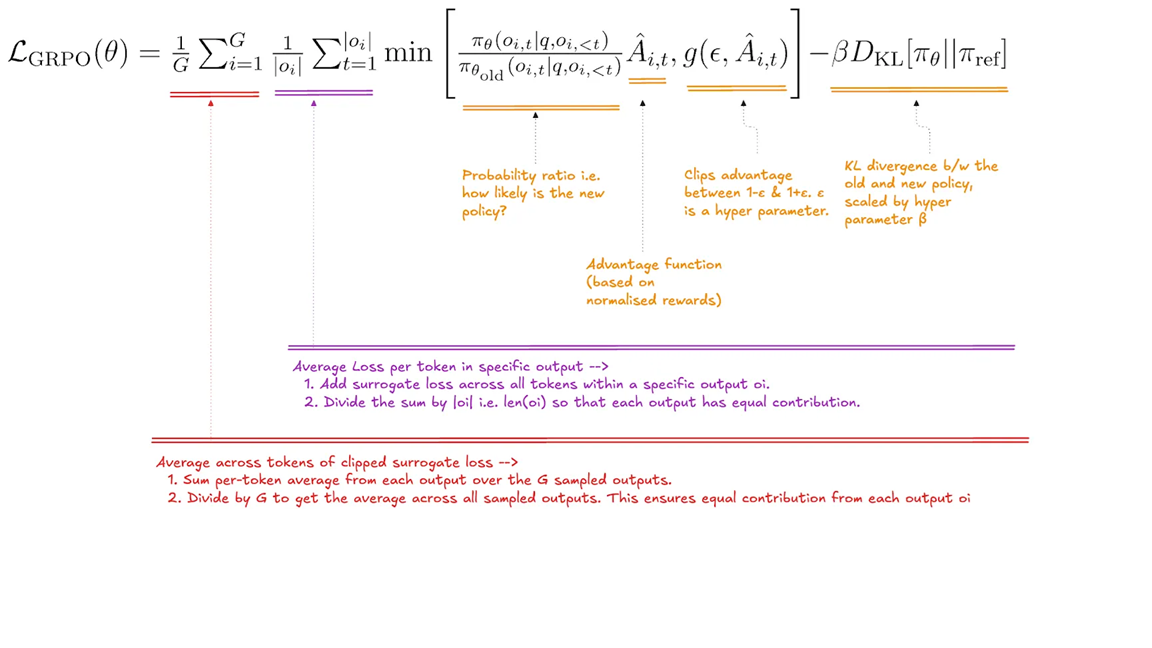

In [ ]:
#RLHF CODE - GET THE BASICS RIGHT
#dataset roneneldan/TinyStories
!git clone https://github.com/karpathy/mingpt.git
%cd mingpt
!pip install .
!pip install nltk


In [ ]:
import copy , os , datasets , torch , nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

import sys
# Install mingpt using pip
!pip install mingpt

from mingpt.model import GPT
#from mingpt.char_tokenizer import CharTokenizer
#from mingpt.logger import Logger
from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed

In [ ]:
import copy , os , datasets , torch , nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

import sys
# Install mingpt using pip
!pip install mingpt

from mingpt.model import GPT
#from mingpt.char_tokenizer import CharTokenizer
#from mingpt.logger import Logger
from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed

class CharTokenizer():
  pad_char = "-"
  eot_char = "⏎"

  def __init__(self,data):
    chars = sorted(list(set(data) | {self.pad_char, self.eot_char})) # creating vocab of all unique characters
    data_size , vocab_size = len(data) , len(chars)
    print("data has %d characters , %d unique" % (data_size,vocab_size))
    self.stoi = {ch:i for i,ch in enumerate(chars)} #string to integer
    self.itos = {i:ch for i,ch in enumerate(chars)} #integer to string
    self.vocab_size = vocab_size
    self.pad_token = self.stoi[self.pad_char]
    self.eot_token = self.stoi[self.eot_char]

  def __call__(self, text:str) ->torch.LongTensor:
    # Corrected the way of creating a LongTensor from a list
    return torch.tensor([self.stoi[c] for c in text if c in self.stoi], dtype=torch.long)
  def decode(self, tokens ,ignore_padding = False) ->str:
    return "".join([self.itos[i] for i in tokens.tolist() if i in self.itos and not ignore_padding or i != self.pad_token])

In [ ]:
class StoryDataset(Dataset):
  """TinyStories Dataset https://huggingface.co/datasets/roneneldan/TinyStories"""

  def __init__(self,block_size, split="train",filter_sentiment= None , tokenizer = None):
    super().__init__()
    self.block_size = block_size
    self.split = split
    self.filter_sentiment = filter_sentiment
    self.tokenizer = tokenizer
    eot_char = "⏎"

    #helper function to process and chunk the text examples
    def chunk_examples(examples):
      chunks = [(eot_char+text+eot_char) for text in examples['text'] if len(text)>0]
      return {"content":chunks}
      print(f"Loading TinyStories dataset for split:{split}")
    dataset = datasets.load_dataset("roneneldan/TinyStories",split = split)

    #filter the dataset for by sentiment for SFT
    if filter_sentiment:
      sid = SentimentIntensityAnalyzer()
      def is_positive(example):
        return sid.polarity_scores(example['text'])['compound'] > 0.5
      if filter_sentiment == "positive":
        dataset = dataset.filter(is_positive)
      else:
        pass
    self.dataset = dataset.map(chunk_examples , batched= True , remove_columns = dataset.column_names)

    #intialize tokenizer
    if self.tokenizer is None:
      print("Building a new tokenizer")
      token_text_example = "".join(row["content"] for row in self.dataset.select(range(10000)))
      self.tokenizer = CharTokenizer(token_text_example)
      print("Tokenizer built")

  def get_vocab_size(self):
    return self.tokenizer.vocab_size
  def get_block_size(self):
    return self.block_size
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self,idx):
    chunk = self.dataset[idx]["content"]
    tokens = self.tokenizer(chunk)
    assert(len(tokens)) >0
    if len(tokens) >=self.block_size +1:
      toks = tokens[:self.block_size+1]
    else:
      pad = torch.full((self.block_size+1,),self.tokenizer.pad_token , dtype = torch.long)
      pad[:len(tokens)] = tokens # Use 'tokens' instead of 'toks'
      toks = pad
    x = toks[:-1]
    y = toks[1:].clone() #creating target label sequence by shifting the intial sequence by 1
    y[y==self.tokenizer.pad_token] = -1 # masks padding in the target

    #our mask is true for padding / unused tasks
    #to match the causal masking inside the miniGPT model
    attn_mask = x ==self.tokenizer.pad_token #attention should not be paid to pad_token
    return x, y ,attn_mask #returns input , output and attn_mask

class SentimentRewardModel():
  def __init__(self,tokenizer):
    self.tokenizer = tokenizer
    self.sid = SentimentIntensityAnalyzer()
  def sentiment(self,sentence:str) ->float:
    #retun a "compound" score which is normalized , weighted composite sentiment score
    return self.sid.polarity_scores(sentence)['compound']
  def __call__(self,tokens):
    bs = tokens.shape[0]
    rewards = torch.zeros(bs)
    for i in range(bs):
      #decode the tokens back into a sequence
      sentence = self.tokenizer.decode(tokens[i])
      #calculate the sentiment score for the decoded sentence
      rewards[i] = self.sentiment(sentence)
    return rewards.to(tokens.device)

def batch_end_callback(trainer):
  model = trainer.model
  model.eval()
  if trainer.iter_num % 100 == 0:
    print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
    with torch.nograd():
      total_loss = 0
      for i , batch in enumerate(valid_loader):
        x,y, mask = [x.to(trainer.device) for x in batch]
        logits , loss = model(x,y,attention_mask = mask)
        total_loss +=loss.item()
    val_loss = total_loss/(i+1)
    print(f"iter {trainer.iter_num}: val loss {val_loss:.5f}")
  if trainer.iter_num % trainer.config.generate_every == 0:
    with torch.nograd():
      context = train_ds.tokenizer(TEST_PROMPT)[None]
      x = context.to(trainer.device)
      y = model.generate(x,140,temperature = 1.0 , do_sample= True,top_k=20)[0]
      completion = train_ds.tokenizer.decode(y)
  model.train()
if __name__ == '__main__':
  set_seed(42)
  TEST_PROMPT =  "⏎Once upon a time, "
  block_size = 64
  print("===== STARTING PRETRAINING on TinyStories =====") - Policy Model
  #intialize datasets
  train_ds = StoryDataset(block_size , split = "train")
  valid_ds = StoryDataset(block_size , split = "validation")
  end_of_text = train_ds.tokenizer.eot_token

  #model configuration
  model_config = GPT.get_default_config()
  model_config.model_type = "gpt-micro"
  model_config.vocab_size = train_ds.get_vocab_size()
  model_config.block_size = block_size
  model = GPT(model_config)


  # Trainer Configuration
  train_config = Trainer.get_default_config()
  train_config.learning_rate = 5e-4 # Slightly adjusted learning rate
  train_config.num_workers = 4 # Use more workers if your machine supports it
  train_config.log_every = 2000
  train_config.generate_every = 5000
  # TinyStories is huge, so 1 epoch is already a lot of training
  train_config.epochs = 1
  train_config.compile = True # Use torch.compile for a speedup if available
  train_config.batch_size = 128 # Increase batch size if GPU memory allows

  trainer = Trainer(train_config, model, train_ds)
  device = trainer.device

  valid_loader = DataLoader(
      valid_ds,
      shuffle=False,
      batch_size=trainer.config.batch_size*2,
      num_workers=train_config.num_workers,
  )
  trainer.set_callback("on_batch_end", batch_end_callback)
  trainer.run()
  print("\n===== DONE PRETRAINING =====")

  # Save the pretrained model
  print("\n===== SAVING PRETRAINED MODEL =====")
  pretrained_ckpt_path = os.path.join(os.path.curdir, "story_gpt_pretrained.pt")
  torch.save(model.state_dict(), pretrained_ckpt_path)
  print("\n===== DONE SAVING =====")

  #generate a sample after pretraining
  sample_prompt = torch.full((3,1),end_of_text,dtype = torch.long,device = device)
  idx = model.generate(sample_prompt, max_new_tokens = 80,top_k=30, do_sample = True)
  for j , generation in enumerate(idx):
    print(f"Pre Trained Generation {j+1}:", train_ds.tokenizer.decode(generation))


  print("\n===== STARTING SUPERVISED FINE-TUNING (SFT) =====")
  sft_dataset = StoryDataset(block_size, split="train", filter_sentiment="positive", tokenizer=train_ds.tokenizer)
  sft_valid = StoryDataset(block_size, split="validation", filter_sentiment="positive", tokenizer=train_ds.tokenizer)
  sft_loader = DataLoader(
      sft_dataset,
      shuffle=True,
      batch_size=train_config.batch_size,
      num_workers=train_config.num_workers,
  )
  #adjust the training config for fine tuning for base   model = GPT(model_config)
  train_config.learning_rate = 1e-4 # lower learning rate for fine tuning
  train_config.epochs = 2 # only two epochs

  trainer = Trainer(train_config, model, sft_loader)
  trainer.set_callback("on_batch_end", batch_end_callback)
  trainer.run()
  print("\n===== DONE SFT =====")

  #check generation from SFT model
  idx = model.generate(sample_prompt, max_new_tokens = 80,top_k=30, do_sample = True)
  for j , generation in enumerate(idx):
    print(f"SFT Generation {j+1}:", train_ds.tokenizer.decode(generation))

  print("\n===== STARTING RL IN-CONTEXT LEARNING (ICL) =====")
  ref_model = copy.deepcopy(model)
  ref_model.requires_grad(False) #why as we want the policy model weights to not change
  ref_model.eval()

  #reward model
  reward_model = SentimentRewardModel(train_ds.tokenizer)
  #RL paramaters
  batch_size = 64
  num_iters = 200
  learning_rate = 1e-5
  grad_norm_clip = 1.0
  kl_beta = 0.1 # kl divergence coeff

  model.to(device)
  logger = Logger()
  optimizer  = torch.optim.Adam(model.parameters(),lr = learning_rate, betas=(0.9,0.95))
  prompt = torch.full((batch_size,1),end_of_text,dtype = torch.long,device = device)

  print("Starting RL training loop...")
  for i in range(num_iters):
    with torch.nograd():
      model.eval()
      completion = model.generate(prompt,140,temperature = 1.0 , do_sample= True,top_k=30)
      model.train()
      rewards = reward_model(completion)
      ref_log_probs = ref_model.log_probs(completion[:,:1], completion[:,1:])

    log_probs = model.log_probs(completion[:,:1], completion[:,1:])
    kl = log_probs - ref_log_probs
    # the score is a combination of the reward and KL penalty to prevent the model from deviating too far from the reference
    score = rewards[:,None] - kl_beta*kl
    score = score.detach()

    #vanilla policy gradient loss
    pg_loss = -torch.mean(score*log_probs)
    loss = pg_loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
    optimizer.step()
    optimizer.zero_grad()

    if i %50 ==0:
      model.eval()
      idx = model.generate(prompt,140,temperature = 1.0 , do_sample= True,top_k=30).cpu()
      for j , generation in enumerate(idx):
        print(f"RL Generation {j+1}:", train_ds.tokenizer.decode(generation))
      model.train()
  print("RL DONE")

  idx = model.generate(sample_prompt, max_new_tokens = 80,top_k=30, do_sample = True)
  for j , generation in enumerate(idx):
    print(f"RL Generation {j+1}:", train_ds.tokenizer.decode(generation))